In [1]:
# 引入依赖库
import pandas as pd
import torch
import matplotlib.pyplot as plt
from sklearn import preprocessing
from utils import *
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, r2_score
from torch.utils.data import DataLoader, TensorDataset
import os
import math
import numpy as np
import torch.optim as optim
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from pandas import DataFrame, concat
from sklearn.model_selection import KFold

/root/miniconda/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 必要参数定义
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # 训练设备,如果NVIDIA GPU已配置，会自动使用GPU训练
train_ratio = 0.8  # 训练集比例
val_ratio = 0.1  # 验证集比例
test_ratio = 0.1  # 测试集比例
batch_size = 50  # 批大小，若用CPU，建议为1
input_length = 4  # 每个batch的输入数据长度，多步预测建议长，单步预测建议短
output_length = 1  # 每个batch的输出数据长度，1为单步预测，1以上为多步预测
loss_function = 'MSE'  # 损失函数定义
learning_rate = 0.001  # 基础学习率
weight_decay = 0.001  # 权重衰减系数
num_blocks = 2  # lstm堆叠次数
dim = 128  # 隐层维度
interval_length = 55000  # 预测数据长度，最长不可以超过总数据条数
scalar = True  # 是否使用归一化
scalar_contain_labels = True  # 归一化过程是否包含目标值的历史数据
target_value = 'T (degC)'  # 需要预测的列名，可以在excel中查看
# 多步，单步标签
if output_length > 1:
    forecasting_model = 'multi_steps'
else:
    forecasting_model = 'one_steps'

In [3]:
csv_path = "./weather.csv"
df = pd.read_csv(csv_path, encoding='utf-8')

In [4]:
print(df.shape)

(52696, 22)


In [5]:
titles = [
    "Pressure",
    "Temperature",
    "Temperature in Kelvin",
    "Temperature (dew point)",
    "Relative Humidity",
    "Saturation vapor pressure",
    "Vapor pressure",
    "Vapor pressure deficit",
    "Specific humidity",
    "Water vapor concentration",
    "Airtight",
    "Wind speed",
    "Maximum wind speed",
    "Wind direction in degrees",
]

feature_keys = [
    "p (mbar)",
    "T (degC)",
    "Tpot (K)",
    "Tdew (degC)",
    "rh (%)",
    "VPmax (mbar)",
    "VPact (mbar)",
    "VPdef (mbar)",
    "sh (g/kg)",
    "H2OC (mmol/mol)",
    "rho (g/m**3)",
    "wv (m/s)",
    "max. wv (m/s)",
    "wd (deg)",
]

colors = [
    "blue",
    "orange",
    "green",
    "red",
    "purple",
    "brown",
    "pink",
    "gray",
    "olive",
    "cyan",
]

date_time_key = "date"

In [6]:
print(
    "选取的参数指标是:",
    ", ".join([titles[i] for i in [0, 1, 5, 7, 8, 10, 11]]),
)
selected_features = [feature_keys[i] for i in [0, 1, 5, 7, 8, 10, 11]]
features = df[selected_features]
features.index = df[date_time_key]
features.head()

选取的参数指标是: Pressure, Temperature, Saturation vapor pressure, Vapor pressure deficit, Specific humidity, Airtight, Wind speed


,p (mbar),T (degC),VPmax (mbar),VPdef (mbar),sh (g/kg),rho (g/m**3),wv (m/s)
date,,,,,,,
2020-01-01 00:10:00,1008.89,0.71,6.43,0.89,3.42,1280.62,1.02
2020-01-01 00:20:00,1008.76,0.75,6.45,0.95,3.39,1280.33,0.43
2020-01-01 00:30:00,1008.66,0.73,6.44,0.96,3.39,1280.29,0.61
2020-01-01 00:40:00,1008.64,0.37,6.27,0.86,3.35,1281.97,1.11
2020-01-01 00:50:00,1008.61,0.33,6.26,0.79,3.38,1282.08,0.49


In [7]:
# 原始数据集存在重复项，要进行去重
df.drop_duplicates(subset=["date"],keep='first',inplace=True)

In [8]:
print(df.keys())

Index(['date', 'p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)', 'rh (%)',
       'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)',
       'H2OC (mmol/mol)', 'rho (g/m**3)', 'wv (m/s)', 'max. wv (m/s)',
       'wd (deg)', 'rain (mm)', 'raining (s)', 'SWDR (W/m�)',
       'PAR (�mol/m�/s)', 'max. PAR (�mol/m�/s)', 'Tlog (degC)', 'OT'],
      dtype='object')


In [9]:

#wind speed中含有明显的异常值，需进行去除
df['z_score'] = (df['wv (m/s)'] - df['wv (m/s)'].mean()) / df['wv (m/s)'].std()
# 过滤掉 Z-Score 大于 3 或小于 -3 的数据点
df['wv (m/s)'][(df['z_score'] < -3) | (df['z_score'] > 3)] = 0

/tmp/ipykernel_23764/3152412068.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['wv (m/s)'][(df['z_score'] < -3) | (df['z_score'] > 3)] = 0


In [10]:
df['Date Time'] = pd.to_datetime(df['date'])  # 确保时间列是日期时间格式
df.set_index('Date Time', inplace=True)  # 将时间列设为索引

# 填充缺失值
df.fillna(method='pad', inplace=True)

# 选择目标列和观察列
target = df['T (degC)']
observed_cov = df[['p (mbar)', 'VPmax (mbar)', 'VPdef (mbar)', 'sh (g/kg)', 'rho (g/m**3)', 'wv (m/s)']]

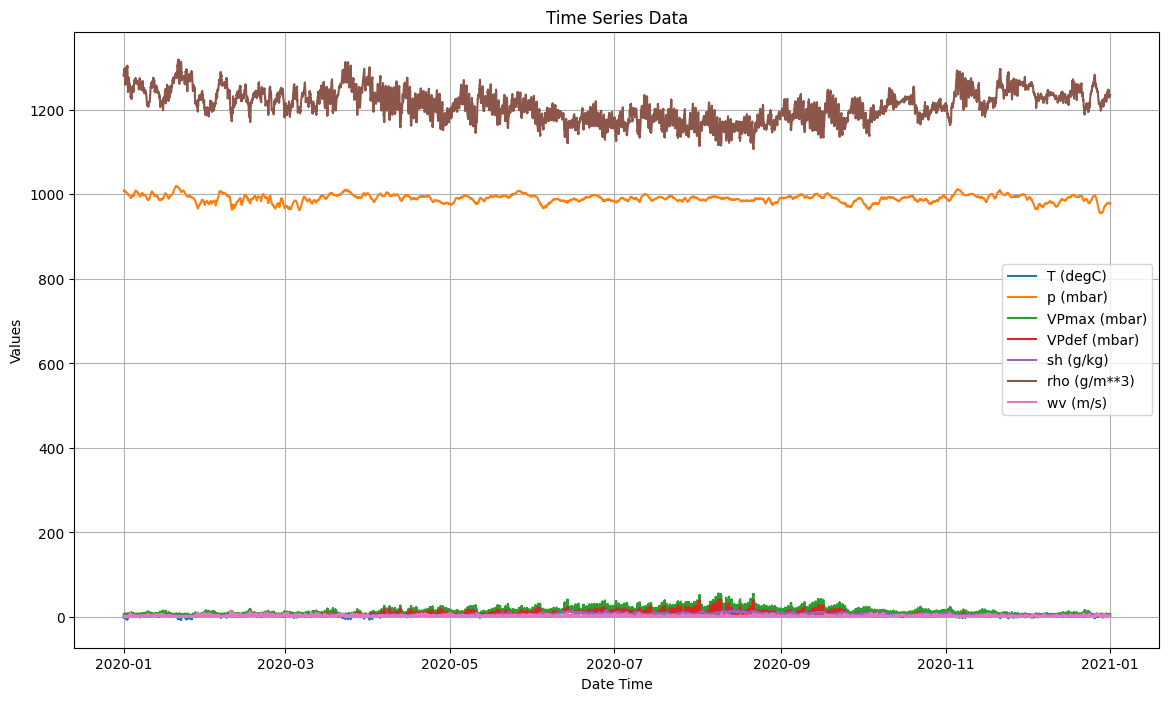

In [11]:
# 绘制目标和观察列
plt.figure(figsize=(14, 8))

# 绘制每一列
for column in ['T (degC)', 'p (mbar)', 'VPmax (mbar)', 'VPdef (mbar)', 'sh (g/kg)', 'rho (g/m**3)', 'wv (m/s)']:
    plt.plot(df.index, df[column], label=column)

plt.title('Time Series Data')
plt.xlabel('Date Time')
plt.ylabel('Values')
plt.legend()
plt.grid()
plt.show()

In [12]:
# 获取指定列的总结统计信息
selected_columns = ['T (degC)', 'p (mbar)', 'VPmax (mbar)', 'VPdef (mbar)', 'sh (g/kg)', 'rho (g/m**3)', 'wv (m/s)']
summary = df[selected_columns].describe()

# 打印出选择列的总结统计信息
print(summary)


           T (degC)      p (mbar)  VPmax (mbar)  VPdef (mbar)     sh (g/kg)  \
count  52695.000000  52695.000000  52695.000000  52695.000000  52695.000000   
mean      10.818476    989.989203     14.487217      4.810218      6.111212   
std        7.468546      9.207234      7.632931      5.539336      2.561531   
min       -6.440000    955.580000      3.770000      0.000000      1.300000   
25%        4.590000    984.800000      8.480000      1.170000      4.070000   
50%       10.230000    990.920000     12.480000      2.740000      5.610000   
75%       16.180000    995.930000     18.420000      6.440000      7.620000   
max       34.800000   1020.070000     55.670000     42.100000     15.400000   

       rho (g/m**3)      wv (m/s)  
count  52695.000000  52695.000000  
mean    1210.881746      2.185705  
std       36.429680      1.601631  
min     1107.380000      0.000000  
25%     1183.900000      1.000000  
50%     1210.800000      1.770000  
75%     1236.550000      2.920000  


In [13]:
df_1=df[selected_columns]
df_1.head()

,T (degC),p (mbar),VPmax (mbar),VPdef (mbar),sh (g/kg),rho (g/m**3),wv (m/s)
Date Time,,,,,,,
2020-01-01 00:10:00,0.71,1008.89,6.43,0.89,3.42,1280.62,1.02
2020-01-01 00:20:00,0.75,1008.76,6.45,0.95,3.39,1280.33,0.43
2020-01-01 00:30:00,0.73,1008.66,6.44,0.96,3.39,1280.29,0.61
2020-01-01 00:40:00,0.37,1008.64,6.27,0.86,3.35,1281.97,1.11
2020-01-01 00:50:00,0.33,1008.61,6.26,0.79,3.38,1282.08,0.49


In [14]:
#  读取数据
df = df_1[:interval_length]
features_num = 7  # 请手动输入特征维度数量
if features_num > 1:
    features_ = df.values
else:
    features_ = df[target_value].values
labels_ = df[target_value].values
# 初步划分训练集、验证集、测试集
split_train_val, split_val_test = int(len(features_)*train_ratio),\
                                  int(len(features_)*train_ratio)+int(len(features_)*val_ratio)

In [15]:
#  数据标准化
if scalar:
    #min-max scalar
    train_features_ = features_[:split_train_val]
    val_test_features_ = features_[split_train_val:]
    scalar = preprocessing.MinMaxScaler()
    if features_num == 1:
        train_features_ = np.expand_dims(train_features_, axis=1)
        val_test_features_ = np.expand_dims(val_test_features_, axis=1)
    train_features_ = scalar.fit_transform(train_features_)
    val_test_features_ = scalar.transform(val_test_features_)
    # 重新将数据进行拼接
    features_ = np.vstack([train_features_, val_test_features_])
    if scalar_contain_labels:
        labels_ = features_[:, -1]

if len(features_.shape) == 1:
    features_ = np.expand_dims(features_,0).T
features, labels = get_rolling_window_multistep(output_length, 0, input_length,
                                                features_.T, np.expand_dims(labels_, 0))

data preparing: 100%|██████████| 52691/52691 [01:09<00:00, 760.61it/s] 


In [16]:
#  构建数据集
labels = torch.squeeze(labels, dim=1)
features = features.to(torch.float32)
labels = labels.to(torch.float32)
split_train_val, split_val_test = int(len(features)*train_ratio), int(len(features)*train_ratio)+int(len(features)*val_ratio)
train_features, train_labels = features[:split_train_val], labels[:split_train_val]
val_features, val_labels = features[split_train_val:split_val_test], labels[split_train_val:split_val_test]
test_features, test_labels = features[split_val_test:], labels[split_val_test:]

In [17]:
#  数据管道构建，此处采用torch高阶API
train_Datasets = TensorDataset(train_features.to(device), train_labels.to(device))
train_Loader = DataLoader(batch_size=batch_size, dataset=train_Datasets)
val_Datasets = TensorDataset(val_features.to(device), val_labels.to(device))
val_Loader = DataLoader(batch_size=batch_size, dataset=val_Datasets)
test_Datasets = TensorDataset(test_features.to(device), test_labels.to(device))
test_Loader = DataLoader(batch_size=batch_size, dataset=test_Datasets)

In [18]:
# 定义 CNN-LSTM 模型
class CNN_LSTM_Attention(nn.Module):
    def __init__(self):
        super(CNN_LSTM_Attention, self).__init__()
        self.conv1d = nn.Conv1d(in_channels=7, out_channels=64, kernel_size=3)
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.lstm1 = nn.LSTM(input_size=64, hidden_size=128, batch_first=True)
        self.attention = nn.MultiheadAttention(embed_dim=128, num_heads=4)
        self.lstm2 = nn.LSTM(input_size=128, hidden_size=128, batch_first=True)
        self.fc = nn.Linear(128,1)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # [batch, n_vars, n_in] -> [batch, n_in, n_vars]
        x = self.conv1d(x)
        x = self.pool(x)
        x = x.permute(0, 2, 1)  # 调整为 [batch, 时间步, 通道数]
        lstm_out, _ = self.lstm1(x)
        attn_output, _ = self.attention(lstm_out, lstm_out, lstm_out)
        lstm_out, _ = self.lstm2(attn_output)
        x = lstm_out[:, -1, :]  # 获取最后一个时间步的输出
        x = self.fc(x)
        return x

In [19]:
# 创建模型、损失函数和优化器
model = CNN_LSTM_Attention()
model.to(device)
if loss_function == 'MSE':
    loss_func = nn.MSELoss(reduction='mean')

In [20]:
#  训练代数定义
epochs = 21
#  优化器定义，学习率衰减定义
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs//3, eta_min=0.00001)

In [21]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from sklearn.metrics import r2_score

# Lists to store MAE, RMSE, and R² for each epoch
train_mae_history = []
train_rmse_history = []
train_r2_history = []
val_mae_history = []
val_rmse_history = []
val_r2_history = []

print("——————————————————————Training Starts——————————————————————")
torch.autograd.set_detect_anomaly(True)
for epoch in range(epochs):
    # Training
    model.train()
    train_loss_sum = 0
    train_mae_sum = 0
    train_rmse_sum = 0
    all_train_preds = []
    all_train_labels = []
    for step, (feature_, label_) in enumerate(train_Loader):
        optimizer.zero_grad()
        feature_ = feature_.permute(0, 2, 1)
        prediction = model(feature_)
        loss = loss_func(prediction, label_)
        loss.backward()
        torch.nn.utils.clip_grad_norm(model.parameters(), 0.15)
        optimizer.step()
        train_loss_sum += loss.item()
        
        # Store predictions and labels for R² calculation
        all_train_preds.append(prediction.detach().cpu().numpy())
        all_train_labels.append(label_.detach().cpu().numpy())
        
        # Calculate MAE and RMSE for this batch
        mae = torch.mean(torch.abs(prediction - label_)).item()
        rmse = torch.sqrt(torch.mean((prediction - label_) ** 2)).item()
        train_mae_sum += mae
        train_rmse_sum += rmse

    # Calculate R² for training data for the entire epoch
    all_train_preds = np.concatenate(all_train_preds)
    all_train_labels = np.concatenate(all_train_labels)
    train_r2 = r2_score(all_train_labels, all_train_preds)
    
    # Record each epoch's metrics
    train_mae_history.append(train_mae_sum / (step + 1))  # Average MAE per epoch
    train_rmse_history.append(train_rmse_sum / (step + 1))  # Average RMSE per epoch
    train_r2_history.append(train_r2)

    print(f"Epoch {epoch}: Train Loss = {train_loss_sum:.4f}, Train MAE = {train_mae_history[-1]:.4f}, Train RMSE = {train_rmse_history[-1]:.4f}, Train R² = {train_r2:.4f}")

    # Validation
    model.eval()
    val_loss_sum = 0
    val_mae_sum = 0
    val_rmse_sum = 0
    all_val_preds = []
    all_val_labels = []
    for val_step, (feature_, label_) in enumerate(val_Loader):
        feature_ = feature_.permute(0, 2, 1)
        with torch.no_grad():
            prediction = model(feature_)
            val_loss = loss_func(prediction, label_)
        val_loss_sum += val_loss.item()
        
        # Store predictions and labels for R² calculation
        all_val_preds.append(prediction.cpu().numpy())
        all_val_labels.append(label_.cpu().numpy())
        
        # Calculate MAE and RMSE for this batch
        mae = torch.mean(torch.abs(prediction - label_)).item()
        rmse = torch.sqrt(torch.mean((prediction - label_) ** 2)).item()
        val_mae_sum += mae
        val_rmse_sum += rmse

    # Calculate R² for validation data for the entire epoch
    all_val_preds = np.concatenate(all_val_preds)
    all_val_labels = np.concatenate(all_val_labels)
    val_r2 = r2_score(all_val_labels, all_val_preds)
    
    # Record each epoch's metrics
    val_mae_history.append(val_mae_sum / (val_step + 1))  # Average MAE per epoch
    val_rmse_history.append(val_rmse_sum / (val_step + 1))  # Average RMSE per epoch
    val_r2_history.append(val_r2)

    print(f"Epoch {epoch}: Val Loss = {val_loss_sum:.4f}, Val MAE = {val_mae_history[-1]:.4f}, Val RMSE = {val_rmse_history[-1]:.4f}, Val R² = {val_r2:.4f}")

    # Save best model
    if epoch == 0 or val_loss_sum < val_best:
        val_best = val_loss_sum
        #torch.save(model.state_dict(), './CNN_LSTM/CNN_LSTM_best')  # Save best weights
        print("val_best change")
    '''
    # Save model every 10 epochs
    if epoch % 10 == 0 and epoch >= 10:
        torch.save(model.state_dict(), f'./CNN_LSTM/CNN_LSTM_epoch_{epoch}.pth')
        print(f"Model saved at epoch {epoch}")
    '''

print("best val loss = " + str(val_best))
print("——————————————————————Training Ends——————————————————————")


——————————————————————Training Starts——————————————————————


/tmp/ipykernel_23764/470983901.py:30: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model.parameters(), 0.15)


Epoch 0: Train Loss = 8.2742, Train MAE = 0.0679, Train RMSE = 0.0802, Train R² = 0.3153
Epoch 0: Val Loss = 0.4252, Val MAE = 0.0457, Val RMSE = 0.0557, Val R² = 0.6328
val_best change


/tmp/ipykernel_23764/470983901.py:30: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model.parameters(), 0.15)


Epoch 1: Train Loss = 3.0697, Train MAE = 0.0435, Train RMSE = 0.0542, Train R² = 0.7460
Epoch 1: Val Loss = 0.3034, Val MAE = 0.0419, Val RMSE = 0.0511, Val R² = 0.7387
val_best change


/tmp/ipykernel_23764/470983901.py:30: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model.parameters(), 0.15)


Epoch 2: Train Loss = 2.8331, Train MAE = 0.0424, Train RMSE = 0.0527, Train R² = 0.7656
Epoch 2: Val Loss = 0.2634, Val MAE = 0.0389, Val RMSE = 0.0475, Val R² = 0.7735
val_best change


/tmp/ipykernel_23764/470983901.py:30: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model.parameters(), 0.15)


Epoch 3: Train Loss = 2.6593, Train MAE = 0.0413, Train RMSE = 0.0513, Train R² = 0.7800
Epoch 3: Val Loss = 0.3501, Val MAE = 0.0425, Val RMSE = 0.0515, Val R² = 0.6983


/tmp/ipykernel_23764/470983901.py:30: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model.parameters(), 0.15)


Epoch 4: Train Loss = 2.3935, Train MAE = 0.0389, Train RMSE = 0.0487, Train R² = 0.8020
Epoch 4: Val Loss = 0.2259, Val MAE = 0.0352, Val RMSE = 0.0433, Val R² = 0.8051
val_best change


/tmp/ipykernel_23764/470983901.py:30: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model.parameters(), 0.15)


Epoch 5: Train Loss = 2.0323, Train MAE = 0.0360, Train RMSE = 0.0454, Train R² = 0.8318
Epoch 5: Val Loss = 0.2586, Val MAE = 0.0385, Val RMSE = 0.0478, Val R² = 0.7775


/tmp/ipykernel_23764/470983901.py:30: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model.parameters(), 0.15)


Epoch 6: Train Loss = 1.8980, Train MAE = 0.0348, Train RMSE = 0.0441, Train R² = 0.8429
Epoch 6: Val Loss = 0.2108, Val MAE = 0.0334, Val RMSE = 0.0421, Val R² = 0.8184
val_best change


/tmp/ipykernel_23764/470983901.py:30: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model.parameters(), 0.15)


Epoch 7: Train Loss = 1.8423, Train MAE = 0.0341, Train RMSE = 0.0434, Train R² = 0.8476
Epoch 7: Val Loss = 0.2496, Val MAE = 0.0375, Val RMSE = 0.0470, Val R² = 0.7857


/tmp/ipykernel_23764/470983901.py:30: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model.parameters(), 0.15)


Epoch 8: Train Loss = 1.7790, Train MAE = 0.0336, Train RMSE = 0.0428, Train R² = 0.8528
Epoch 8: Val Loss = 0.2519, Val MAE = 0.0385, Val RMSE = 0.0477, Val R² = 0.7833


/tmp/ipykernel_23764/470983901.py:30: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model.parameters(), 0.15)


Epoch 9: Train Loss = 1.6756, Train MAE = 0.0326, Train RMSE = 0.0416, Train R² = 0.8614
Epoch 9: Val Loss = 0.2061, Val MAE = 0.0331, Val RMSE = 0.0418, Val R² = 0.8222
val_best change


/tmp/ipykernel_23764/470983901.py:30: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model.parameters(), 0.15)


Epoch 10: Train Loss = 1.7634, Train MAE = 0.0331, Train RMSE = 0.0422, Train R² = 0.8541
Epoch 10: Val Loss = 0.1902, Val MAE = 0.0319, Val RMSE = 0.0405, Val R² = 0.8360
val_best change


/tmp/ipykernel_23764/470983901.py:30: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model.parameters(), 0.15)


Epoch 11: Train Loss = 1.6287, Train MAE = 0.0319, Train RMSE = 0.0409, Train R² = 0.8652
Epoch 11: Val Loss = 0.1897, Val MAE = 0.0320, Val RMSE = 0.0408, Val R² = 0.8368
val_best change


/tmp/ipykernel_23764/470983901.py:30: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model.parameters(), 0.15)


Epoch 12: Train Loss = 1.7189, Train MAE = 0.0331, Train RMSE = 0.0421, Train R² = 0.8578
Epoch 12: Val Loss = 0.2018, Val MAE = 0.0328, Val RMSE = 0.0411, Val R² = 0.8256


/tmp/ipykernel_23764/470983901.py:30: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model.parameters(), 0.15)


Epoch 13: Train Loss = 1.6593, Train MAE = 0.0324, Train RMSE = 0.0413, Train R² = 0.8627
Epoch 13: Val Loss = 0.1749, Val MAE = 0.0307, Val RMSE = 0.0393, Val R² = 0.8495
val_best change


/tmp/ipykernel_23764/470983901.py:30: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model.parameters(), 0.15)


Epoch 14: Train Loss = 1.5826, Train MAE = 0.0317, Train RMSE = 0.0405, Train R² = 0.8691
Epoch 14: Val Loss = 0.1737, Val MAE = 0.0306, Val RMSE = 0.0392, Val R² = 0.8505
val_best change


/tmp/ipykernel_23764/470983901.py:30: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model.parameters(), 0.15)


Epoch 15: Train Loss = 1.5672, Train MAE = 0.0315, Train RMSE = 0.0403, Train R² = 0.8703
Epoch 15: Val Loss = 0.1681, Val MAE = 0.0299, Val RMSE = 0.0383, Val R² = 0.8551
val_best change


/tmp/ipykernel_23764/470983901.py:30: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model.parameters(), 0.15)


Epoch 16: Train Loss = 1.5350, Train MAE = 0.0312, Train RMSE = 0.0400, Train R² = 0.8730
Epoch 16: Val Loss = 0.1598, Val MAE = 0.0292, Val RMSE = 0.0375, Val R² = 0.8624
val_best change


/tmp/ipykernel_23764/470983901.py:30: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model.parameters(), 0.15)


Epoch 17: Train Loss = 1.4787, Train MAE = 0.0305, Train RMSE = 0.0391, Train R² = 0.8776
Epoch 17: Val Loss = 0.1569, Val MAE = 0.0286, Val RMSE = 0.0367, Val R² = 0.8647
val_best change


/tmp/ipykernel_23764/470983901.py:30: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model.parameters(), 0.15)


Epoch 18: Train Loss = 1.4799, Train MAE = 0.0305, Train RMSE = 0.0392, Train R² = 0.8775
Epoch 18: Val Loss = 0.1558, Val MAE = 0.0284, Val RMSE = 0.0362, Val R² = 0.8655
val_best change


/tmp/ipykernel_23764/470983901.py:30: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model.parameters(), 0.15)


Epoch 19: Train Loss = 1.4878, Train MAE = 0.0305, Train RMSE = 0.0392, Train R² = 0.8769
Epoch 19: Val Loss = 0.1462, Val MAE = 0.0276, Val RMSE = 0.0353, Val R² = 0.8738
val_best change


/tmp/ipykernel_23764/470983901.py:30: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model.parameters(), 0.15)


Epoch 20: Train Loss = 1.4900, Train MAE = 0.0306, Train RMSE = 0.0392, Train R² = 0.8767
Epoch 20: Val Loss = 0.1456, Val MAE = 0.0277, Val RMSE = 0.0353, Val R² = 0.8742
val_best change
best val loss = 0.14563733340764884
——————————————————————Training Ends——————————————————————


In [22]:
np.savez('./CNN_LSTM_Attention_metrics_history.npz', 
         train_mae=train_mae_history, 
         train_rmse=train_rmse_history, 
         train_r2=train_r2_history, 
         val_mae=val_mae_history, 
         val_rmse=val_rmse_history, 
         val_r2=val_r2_history)

In [ ]:
# 训练及验证循环
train_loss_history = []
val_loss_history = []

print("——————————————————————Training Starts——————————————————————")
torch.autograd.set_detect_anomaly(True)

for epoch in range(epochs):
    # 训练
    model.train()
    train_loss_sum = 0
    step = 1
    for step, (feature_, label_) in enumerate(train_Loader):
        optimizer.zero_grad()
        feature_ = feature_.permute(0,2,1)
        prediction = model(feature_)
        loss = loss_func(prediction, label_)
        loss.backward()
        torch.nn.utils.clip_grad_norm(model.parameters(), 0.15)
        optimizer.step()
        train_loss_sum += loss.item()

    # 记录每个 epoch 的训练损失
    train_loss_history.append(train_loss_sum)
    
    print("epochs = " + str(epoch))
    print('train_loss = ' + str(train_loss_sum))

    # 验证
    model.eval()
    val_loss_sum = 0
    val_step = 1
    for val_step, (feature_, label_) in enumerate(val_Loader):
        feature_ = feature_.permute(0, 2, 1)
        with torch.no_grad():
            prediction = model(feature_)
            val_loss = loss_func(prediction, label_)
        val_loss_sum += val_loss.item()

    # 记录每个 epoch 的验证损失
    val_loss_history.append(val_loss_sum)

    print('val_loss = ' + str(val_loss_sum))
    if epoch == 0:
        val_best = val_loss_sum
    else:
        if val_best > val_loss_sum:
            val_best = val_loss_sum
            print("val_best change")
    
    # 每隔一个epoch保存一次模型, 从第10个epoch开始
    if epoch >= 10 and epoch % 1 == 0:
        torch.save(model.state_dict(), f'./cnn_lstm_epoch_{epoch}.pth')  # 保存模型
        print(f"Model saved at epoch {epoch}")

print("best val loss = " + str(val_best))
print("——————————————————————Training Ends——————————————————————")

# 绘制损失曲线
plt.figure(figsize=(10,6))
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curve')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# 训练及验证循环
train_loss_history = []
val_loss_history = []

print("——————————————————————Training Starts——————————————————————")
torch.autograd.set_detect_anomaly(True)

for epoch in range(epochs):
    # 训练
    model.train()
    train_loss_sum = 0
    step = 1
    for step, (feature_, label_) in enumerate(train_Loader):
        optimizer.zero_grad()
        feature_ = feature_.permute(0,2,1)
        prediction = model(feature_)
        loss = loss_func(prediction, label_)
        loss.backward()
        torch.nn.utils.clip_grad_norm(model.parameters(), 0.15)
        optimizer.step()
        train_loss_sum += loss.item()

    # 记录每个 epoch 的训练损失
    train_loss_history.append(train_loss_sum)
    
    print("epochs = " + str(epoch))
    print('train_loss = ' + str(train_loss_sum))

    # 验证
    model.eval()
    val_loss_sum = 0
    val_step = 1
    for val_step, (feature_, label_) in enumerate(val_Loader):
        feature_ = feature_.permute(0, 2, 1)
        with torch.no_grad():
            prediction = model(feature_)
            val_loss = loss_func(prediction, label_)
        val_loss_sum += val_loss.item()

    # 记录每个 epoch 的验证损失
    val_loss_history.append(val_loss_sum)

    print('val_loss = ' + str(val_loss_sum))
    if epoch == 0:
        val_best = val_loss_sum
    else:
        if val_best > val_loss_sum:
            val_best = val_loss_sum
            torch.save(model.state_dict(), './cnn_lstm_100')  # 保存最好权重
            print("val_best change")

print("best val loss = " + str(val_best))
print("——————————————————————Training Ends——————————————————————")

# 绘制损失曲线
plt.figure(figsize=(10,6))
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curve')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#  测试集预测
model.load_state_dict(torch.load('./cnn_lstm_epoch_17.pth'))  # 调用权重
test_loss_sum = 0
step = 0
#  测试集inference
print("——————————————————————Testing Starts——————————————————————")
for step, (feature_, label_) in enumerate(test_Loader):
    feature_ = feature_.permute(0, 2, 1)
    with torch.no_grad():
         if step ==0:
            prediction = model(feature_)
            pre_array = prediction.cpu()
            label_array = label_.cpu()
            loss = loss_func(prediction, label_)
            test_loss_sum += loss.item()
         else:
            prediction = model(feature_)
            pre_array = np.vstack((pre_array, prediction.cpu()))
            label_array = np.vstack((label_array, label_.cpu()))
            loss = loss_func(prediction, label_)
            test_loss_sum += loss.item()
print("test loss = " + str(test_loss_sum))
print("——————————————————————Testing Ends——————————————————————")

——————————————————————Post-Processing——————————————————————


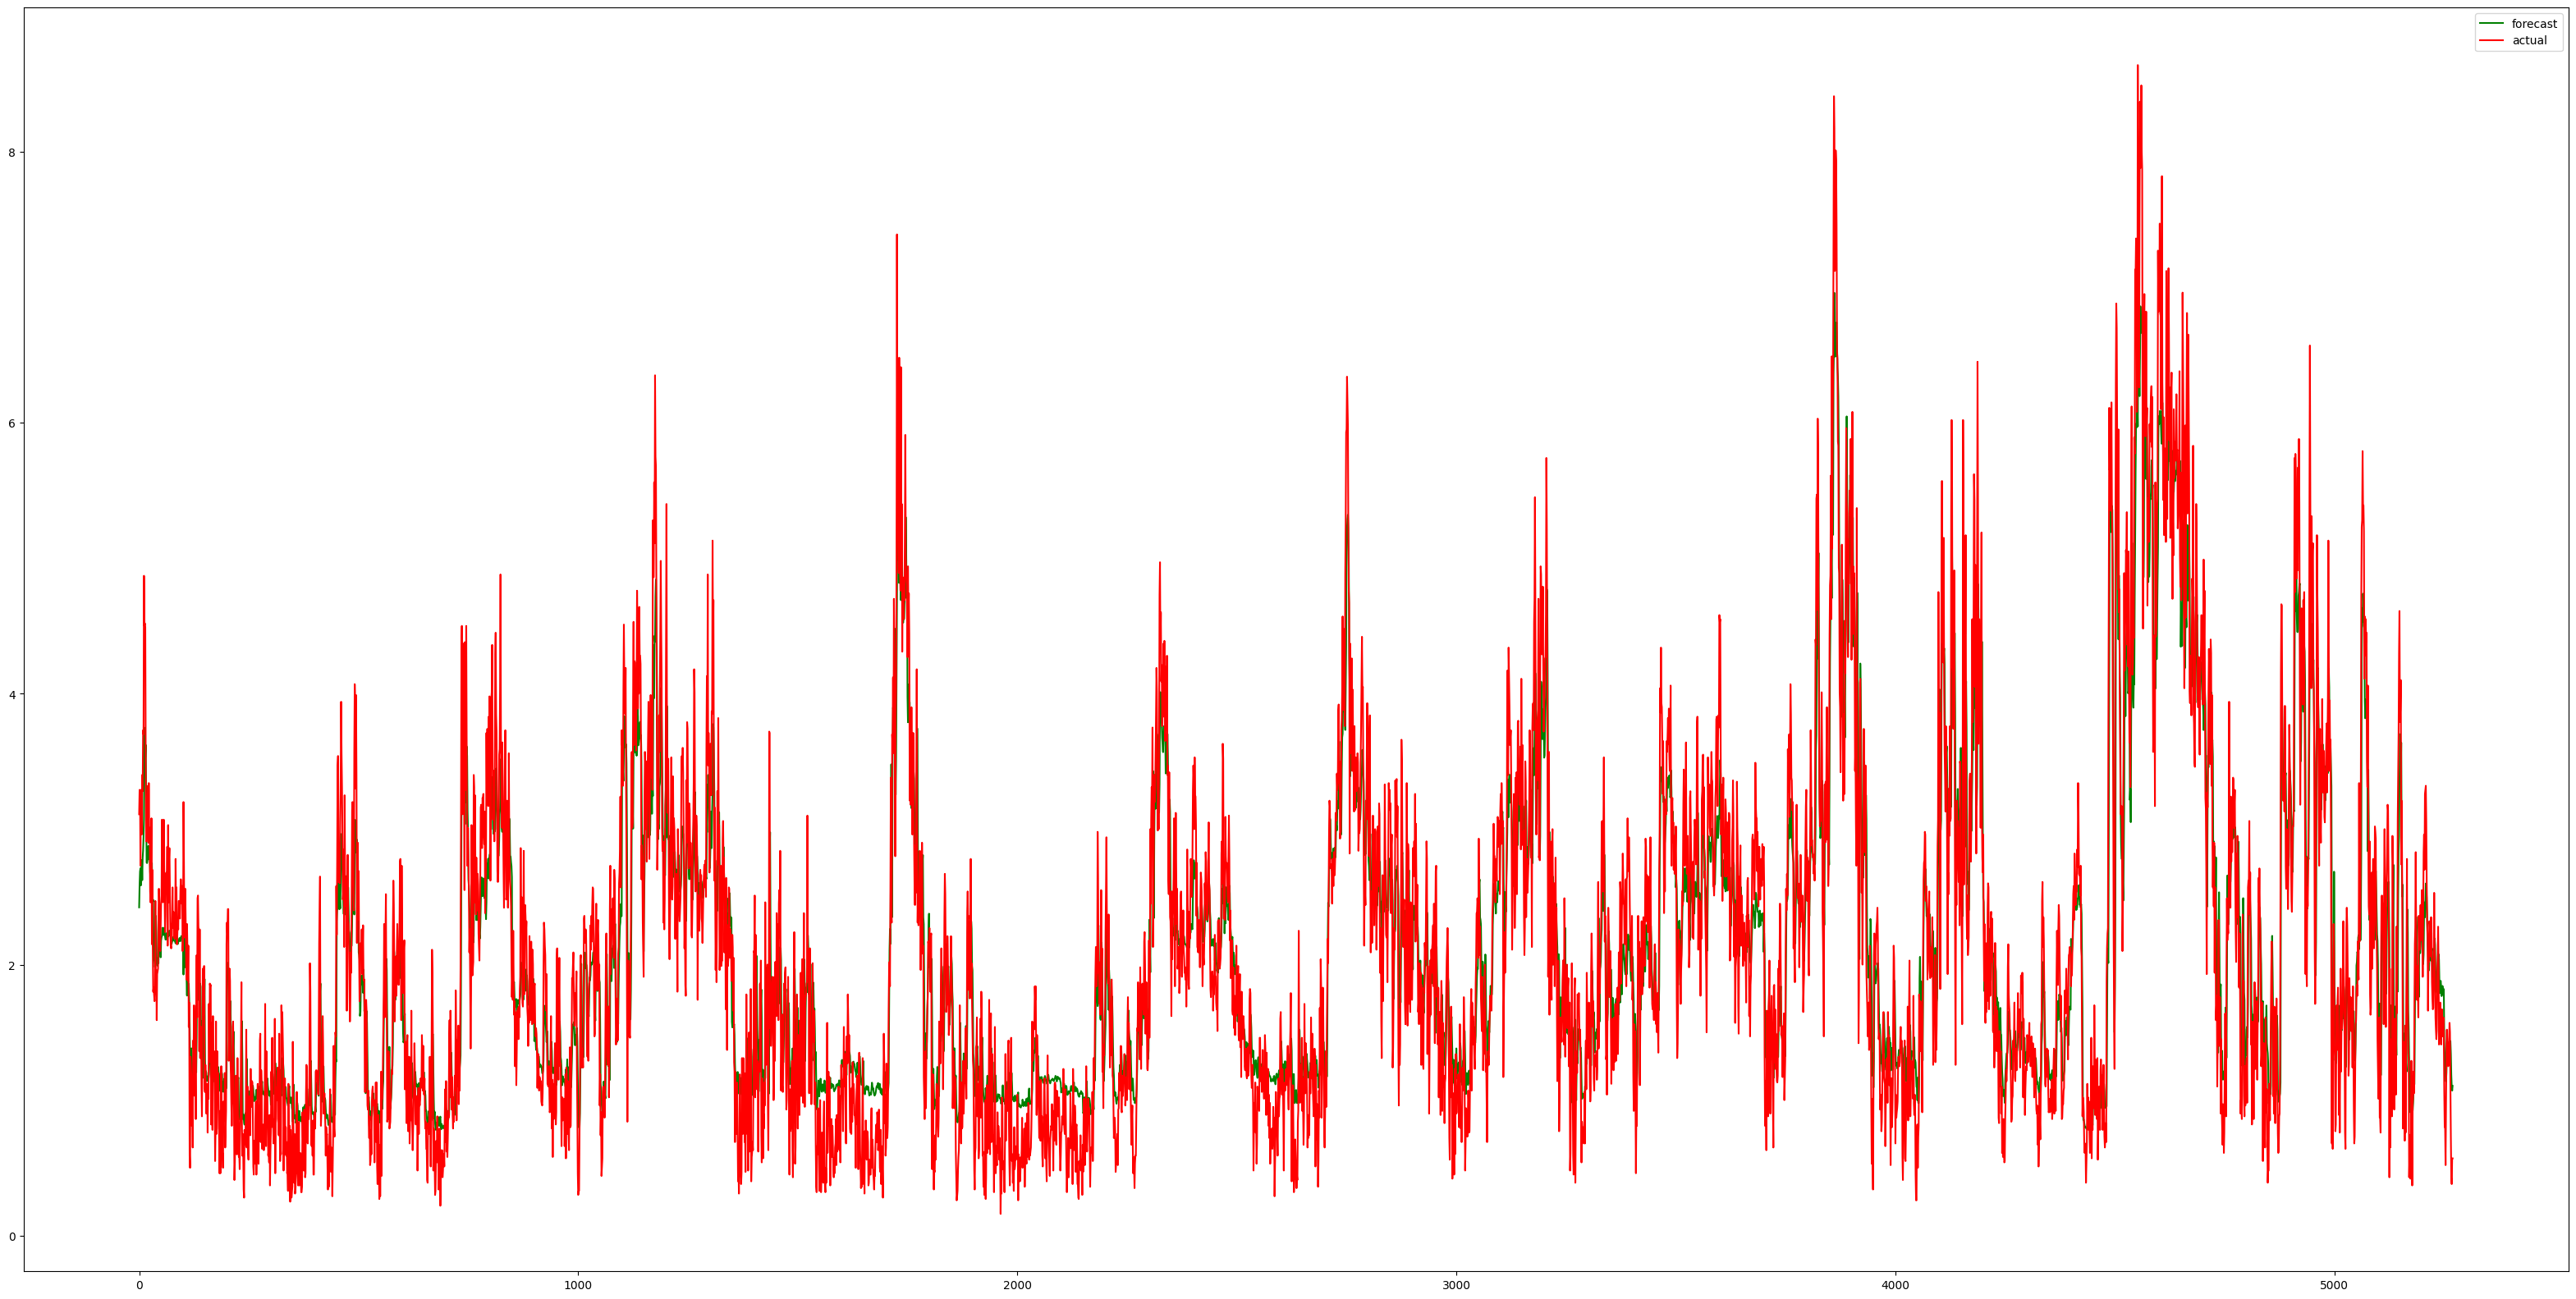

MSE loss=0.25782040579014515
MAE loss=0.3867266215645077
MAPE loss=0.28090852899098717
R2=0.8589320119023793


In [22]:
# 数据后处理，单步预测绘制全部预测值的图像，多步预测仅绘制第一个batch的输出图像
#  逆归一化过程及绘制图像
print("——————————————————————Post-Processing——————————————————————")
#test_labels = torch.tensor(test_labels)

if scalar_contain_labels and scalar :
    pre_inverse = []
    test_inverse = []
    if features_num == 1 and output_length == 1:
        for pre_slice in range(pre_array.shape[0]):
            pre_inverse_slice = scalar.inverse_transform(np.expand_dims(pre_array[pre_slice,:], axis=1))
            test_inverse_slice = scalar.inverse_transform(np.expand_dims(label_array[pre_slice,:], axis=1))
            pre_inverse.append(pre_inverse_slice)
            test_inverse.append(test_inverse_slice)
        pre_array = np.array(pre_inverse).squeeze(axis=-1)
        test_labels = np.array(test_inverse).squeeze(axis=-1)
    elif features_num>1:
        if isinstance(pre_array, np.ndarray):
            pre_array = torch.from_numpy(pre_array)
        for pre_slice in range(pre_array.shape[0]):
            pre_inverse_slice = scalar.inverse_transform(torch.cat((torch.zeros(pre_array[0].shape[0], features_num-1),torch.unsqueeze(pre_array[pre_slice], dim=1)), 1))[:,-1]
            test_inverse_slice = scalar.inverse_transform(torch.cat((torch.zeros(test_labels[0].shape[0], features_num-1), torch.unsqueeze(test_labels[pre_slice], dim=1)), 1))[:,-1]
            pre_inverse.append(pre_inverse_slice)
            test_inverse.append(test_inverse_slice)
        pre_array = np.array(pre_inverse)
        test_labels = np.array(test_inverse)
    else:
        for pre_slice in range(pre_array.shape[0]):
            pre_inverse_slice = scalar.inverse_transform(np.expand_dims(pre_array[pre_slice,:], axis=1))
            test_inverse_slice = scalar.inverse_transform(np.expand_dims(label_array[pre_slice,:], axis=1))
            pre_inverse.append(pre_inverse_slice)
            test_inverse.append(test_inverse_slice)
        pre_array = np.array(pre_inverse).squeeze(axis=-1)
        test_labels = np.array(test_inverse).squeeze(axis=-1)
    plt.figure(figsize=(40,20))
    if forecasting_model == 'multi_steps':
        plt.plot(pre_array[0], 'g')
        plt.plot(test_labels[0], "r")
        plt.legend(["forecast", "actual"], loc='upper right')
        plt.show()
    else:
        plt.plot(pre_array, 'g')
        plt.plot(test_labels, "r")
        plt.legend(["forecast", "actual"], loc='upper right')
        plt.show()
    #  计算衡量指标
    MSE_l = mean_squared_error(test_labels, pre_array)
    MAE_l = mean_absolute_error(test_labels, pre_array)
    MAPE_l = mean_absolute_percentage_error(test_labels, pre_array)
    R2 = r2_score(test_labels, pre_array)
    print('MSE loss=%s'%MSE_l)
    print('MAE loss=%s'%MAE_l)
    print('MAPE loss=%s'%MAPE_l)
    print('R2=%s'%R2)

else:
    plt.figure(figsize=(40,20))
    if forecasting_model == 'multi_steps':
        plt.plot(pre_array[0], 'g')
        plt.plot(test_labels[0].cpu(), "r")
        plt.legend(["forecast", "actual"], loc='upper right')
        plt.show()
    else:
        plt.plot(pre_array, 'g')
        plt.plot(test_labels.cpu(), "r")
        plt.legend(["forecast", "actual"], loc='upper right')
        plt.show()
    MSE_l = mean_squared_error(test_labels.cpu(), pre_array)
    MAE_l = mean_absolute_error(test_labels.cpu(), pre_array)
    MAPE_l = mean_absolute_percentage_error(test_labels.cpu(), pre_array)
    R2 = r2_score(test_labels.cpu(), pre_array)
    print('MSE loss=%s'%MSE_l)
    print('MAE loss=%s'%MAE_l)
    print('MAPE loss=%s'%MAPE_l)
    print('R2=%s'%R2)